In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [17]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [18]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape, labels_batch.shape)
    break

(32, 180, 180, 3) (32,)


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
normalization_layer = layers.Rescaling(1./255)

In [58]:
num_classes = len(class_names)

data_augmentation = keras.Sequential(
    [
        layers.Input(shape=(img_height, img_width, 3)),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

model = Sequential(
    [
        data_augmentation,
        layers.Rescaling(1.0 / 255),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dense(num_classes, name='outputs'),
    ]
)

model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_23 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_19 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │       991,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,015,013 (3.87 MB)

 Trainable params: 1,015,013 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [56]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.2532 - loss: 1.6031 - val_accuracy: 0.4728 - val_loss: 1.3209
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 204ms/step - accuracy: 0.4724 - loss: 1.2770 - val_accuracy: 0.4332 - val_loss: 1.3045
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - accuracy: 0.5209 - loss: 1.1511 - val_accuracy: 0.5300 - val_loss: 1.0854
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.5284 - loss: 1.0991 - val_accuracy: 0.5477 - val_loss: 1.1023
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - accuracy: 0.5833 - loss: 1.0228 - val_accuracy: 0.5872 - val_loss: 1.0462
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.6236 - loss: 0.9672 - val_accuracy: 0.5913 - val_loss: 1.0289
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.6658 - loss: 0.9002 - val_accuracy: 0.6253 - val_loss: 0.9651
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - accuracy: 0.6560 - loss: 0.8709 - val_accu

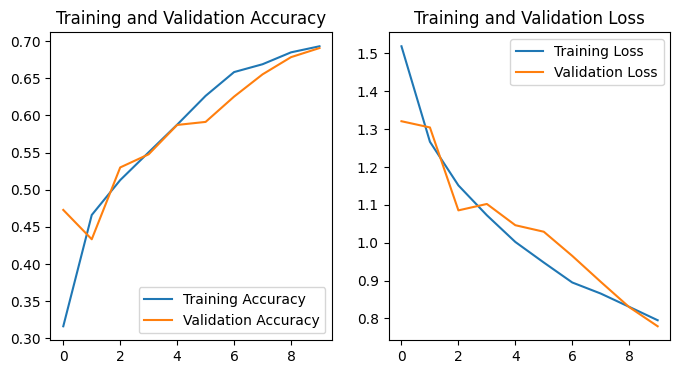

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()